<div class="alert alert-block alert-success"><font color="black"><h1><left>Setup Work For MIMIC Model Creation For Intestinal Model</left></h1></font><P>
<font size="5">- Balance Outcomes</font><P>
<font size="5">- Train/Test/Val Split</font></div>

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
# Notebook Global Variables
# This is replaced with class definitions in initial spreadsheet
icd_category = ['Heart', 'Blood', 'Kidney', 'Lungs']
#icd_category = ['Heart', 'Blood', 'Lungs']
#icd_category = ['Heart']

#icd_codes = ['A41.9', 'I21.4', 'I25.10', 'I34.0', 'I35.2', 'I50.9', 'J18.9', 'J69.0', 'J96.00', 'N17.9']
icd_codes = ['A41.9', 'I21.4', 'J96.00', 'N17.9']
#icd_codes = ['I21.4', 'I25.10', 'I35.2', 'I50.9']
group_type = 'indiv'


In [3]:
path = 'E:/Education/CCSU-Thesis-2024/Data/'
file1 = path + 'full_pd_notes_cleanb.snappy3.parquet'
file2 = path + 'discharge_notes_clean.snappy3.parquet'
# file3 = path + 'base_adms.snappy.parquet'
# file4 = path + 'pd_notes.snappy.parquet'

In [4]:
# Read data and examine counts
# Consistency between pn_notes and bas_adms shows I can eliminate base adm processing now that 
# segmentizing was removed from here and delegated to Hugging Face API
pn_notes = pd.read_parquet(file1,engine='auto',dtype_backend='numpy_nullable')
print('Admissions in pn notes: ', pn_notes.shape[0], 'Unique admissions: ', len(pn_notes['hadm_id'].unique()))
# print(pn_notes[0:3])
discharge_notes = pd.read_parquet(file2,engine='auto',dtype_backend='numpy_nullable')
print('Admissions in discharge notes: ', discharge_notes.shape[0], 'Unique discharge admissions: ', len(discharge_notes['hadm_id'].unique()))
# discharge_notes[0:3]
#base_adms = pd.read_parquet(file3,engine='auto',use_nullable_dtypes=True)
#print('Admissions in base notes: ', base_adms.shape[0], 'Unique base admissions: ', len(base_adms['hadm_id'].unique()))
# base_adms[0:3]



Admissions in pn notes:  5379 Unique admissions:  5379
Admissions in discharge notes:  28449 Unique discharge admissions:  5359


In [5]:
pn_notes.columns

Index(['hadm_id', 'text', 'icd10_code', 'category'], dtype='object')

In [6]:
pn_notes.columns
pn_notes.columns =  ['hadm_id', 'text', 'primary_icd10_code', 'icd_category']
pn_notes['note_length'] = pn_notes['text'].apply(len)

In [7]:
# count output diagnosis codes
un_pn_notes = pn_notes[['primary_icd10_code','hadm_id']].drop_duplicates()
pn_notes.groupby('primary_icd10_code')['hadm_id'].nunique()
#temp_table = ['I21.4', 'I25.10', 'I35.2', 'I50.9']

primary_icd10_code
A41.51     151
A41.9      881
I21.4      950
I25.10    1216
I34.0       74
I35.2      155
I50.23      92
I50.9      301
J18.9      324
J69.0      348
J96.00     625
N17.9      262
Name: hadm_id, dtype: int64

In [8]:
# This cell is added to performe special selection needs priuor to balancing
# for example to set a classes range prior to balancing to produce similar distribution on note size



if group_type == 'indiv':
    
    # This table is for testing diagnosis across body groups
    temp_table = ['I21.4', 'J96.00', 'A41.9', 'N17.9']
    # This table is for testing close heart diagnosis codes
    #temp_table = ['I21.4', 'I25.10', 'I35.2', 'I50.9']
    
    print(temp_table)
    pn_notes_cla = pn_notes[(pn_notes.primary_icd10_code == temp_table[0]) & (pn_notes.note_length < 1000000)]
    print(pn_notes_cla.shape)
    pn_notes_clb = pn_notes[(pn_notes.primary_icd10_code == temp_table[1]) & (pn_notes.note_length < 1000000)]
    print(pn_notes_clb.shape)
    pn_notes_clc = pn_notes[(pn_notes.primary_icd10_code == temp_table[2]) & (pn_notes.note_length < 1000000)]
    print(pn_notes_clc.shape)
    pn_notes_cld = pn_notes[(pn_notes.primary_icd10_code == temp_table[3]) & (pn_notes.note_length < 1000000)]
    print(pn_notes_clc.shape)
else:
    temp_table = icd_category
    pn_notes_cla = pn_notes[(pn_notes.icd_category == temp_table[0]) & (pn_notes.note_length < 100000)]
    print(pn_notes_cla.shape)
    pn_notes_clb = pn_notes[(pn_notes.icd_category == temp_table[1]) & (pn_notes.note_length < 100000)]
    print(pn_notes_clb.shape)
    pn_notes_clc = pn_notes[(pn_notes.icd_category == temp_table[2]) & (pn_notes.note_length < 100000)]
    print(pn_notes_clc.shape)
    


class_train = pd.concat([pn_notes_cla, pn_notes_clb, pn_notes_clc, pn_notes_cld])
print(class_train.shape)
print(' ')
print()
class_train.groupby(['icd_category'])\
                 .agg(min=('note_length', 'min'), median=('note_length','median'),\
                  max=('note_length','max') , count=('hadm_id','count'))
class_train.groupby('primary_icd10_code')['hadm_id'].nunique()

['I21.4', 'J96.00', 'A41.9', 'N17.9']
(950, 5)
(625, 5)
(881, 5)
(881, 5)
(2718, 5)
 



primary_icd10_code
A41.9     881
I21.4     950
J96.00    625
N17.9     262
Name: hadm_id, dtype: int64

In [9]:
import pandasql as ps

qintsl = pn_notes[['hadm_id', 'primary_icd10_code', 'text', 'icd_category']]
# print(qintsl.dtypes)
q1 = """SELECT primary_icd10_code, icd_category, count(distinct hadm_id) FROM qintsl group by primary_icd10_code, icd_category LIMIT 20"""

p1 = ps.sqldf(q1, locals())
print(p1)

   primary_icd10_code icd_category  count(distinct hadm_id)
0              A41.51        Blood                      151
1               A41.9        Blood                      881
2               I21.4        Heart                      950
3              I25.10        Heart                     1216
4               I34.0        Heart                       74
5               I35.2        Heart                      155
6              I50.23        Heart                       92
7               I50.9        Heart                      301
8               J18.9        Lungs                      324
9               J69.0        Lungs                      348
10             J96.00        Lungs                      625
11              N17.9       Kidney                      262


In [10]:
import pandasql as ps

qintsl = pn_notes[['hadm_id', 'text', 'icd_category']]
# print(qintsl.dtypes)
q1 = """SELECT hadm_id, icd_category, length(text), substring(text,0,20) FROM qintsl LIMIT 20"""

p1 = ps.sqldf(q1, locals())
print(p1)

    hadm_id icd_category  length(text) substring(text,0,20)
0    145834        Blood         13425  micu progress nursi
1    143045        Heart          7005  ccu npn s having cp
2    109451        Heart          8373  admission note yr o
3    129635        Heart          9749  ccu progress note t
4    176176        Blood          4329  nsg adm note mr is 
5    188670        Heart          2279  nursing admission n
6    181750        Heart          3841  resp care pt curren
7    116630        Heart          7497  nursing a p see adm
8    127870        Heart          2733  patient admitted s 
9    187373        Heart          3142  pt is a year old ma
10   161160        Lungs          8316  nursing admission p
11   123552        Heart           873  neuro eyes closed n
12   192123        Lungs         18407  nursing progress no
13   198214        Heart          3883  hx y o male present
14   191817        Heart          6970  respiratory care pt
15   151029        Heart          5651  

In [11]:
#sample = random.sample(my_set, 2) 
class_a_id = set(pn_notes_cla.hadm_id)
print(len(pn_notes_cla.hadm_id), len(class_a_id))
print(pn_notes_cla.groupby('primary_icd10_code')['hadm_id'].nunique())
print(pn_notes_clb.groupby('primary_icd10_code')['hadm_id'].nunique())
print(pn_notes_clc.groupby('primary_icd10_code')['hadm_id'].nunique())
pn_notes_cld.groupby('primary_icd10_code')['hadm_id'].nunique()

950 950
primary_icd10_code
I21.4    950
Name: hadm_id, dtype: int64
primary_icd10_code
J96.00    625
Name: hadm_id, dtype: int64
primary_icd10_code
A41.9    881
Name: hadm_id, dtype: int64


primary_icd10_code
N17.9    262
Name: hadm_id, dtype: int64

In [12]:
# Opposed to other authors I did splitting first


#class_a_uniq1 = pn_notes_cla.hadm_id.unique()
#class_a_uniq2 = pn_notes_cla.hadm_id
#class_a_id = np.random.choice(class_a_uniq, ) 
np.random.seed(100)
print('type1:', type(pn_notes_cla.hadm_id), 'type2:', type(pn_notes_cla.hadm_id.unique()))
class_a_id = pd.Series(pn_notes_cla.hadm_id.unique()).sample(n = 260, random_state=100)
class_b_id = pd.Series(pn_notes_clb.hadm_id.unique()).sample(n = 260, random_state=100)
class_c_id = pd.Series(pn_notes_clc.hadm_id.unique()).sample(n = 260, random_state=100)
class_d_id = pd.Series(pn_notes_cld.hadm_id.unique()).sample(n = 260, random_state=100)
#class_a_id = np.random.sample(pn_notes_cla.hadm_id.unique(), size = 150, replace=True)
#class_b_id = np.random.sample(pn_notes_clb.hadm_id.unique(), size = 150, replace=True)
#class_c_id = np.random.sample(pn_notes_clc.hadm_id.unique(), size = 150, replace=True)
#class_d_id = np.random.sample(pn_notes_cld.hadm_id.unique(), size = 150, replace=True)


class_a_test = class_a_id.sample(frac=0.05, random_state=100)
class_b_test = class_b_id.sample(frac=0.05, random_state=100)
class_c_test = class_c_id.sample(frac=0.05, random_state=100)
class_d_test = class_d_id.sample(frac=0.05, random_state=100)

# train
#class_a_train = class_a_id.drop(class_a_test.index)
class_a_train = class_a_id[~class_a_id.isin(class_a_test)]
#class_b_train = class_b_id.drop(class_b_test.index)
class_b_train = class_b_id[~class_b_id.isin(class_b_test)]
#class_c_train = class_c_id.drop(class_c_test.index)
class_c_train = class_c_id[~class_c_id.isin(class_c_test)]
#class_d_train = class_d_id.drop(class_d_test.index)
class_d_train = class_d_id[~class_d_id.isin(class_d_test)]


# split test and val
class_a_val1 = class_a_test.sample(frac=0.5, random_state=100)
class_a_test = class_a_test[~class_a_test.isin(class_a_val1)]
#class_a_test = class_a_test.drop(class_a_val.index)
class_b_val1 = class_b_test.sample(frac=0.5, random_state=100)
#class_b_test = class_b_test.drop(class_b_val.index)
class_b_test = class_b_test[~class_b_test.isin(class_b_val1)]
class_c_val1 = class_c_test.sample(frac=0.5, random_state=100)
class_c_test = class_c_test[~class_c_test.isin(class_c_val1)]
#class_c_test = class_c_test.drop(class_c_val.index)
class_d_val1 = class_d_test.sample(frac=0.5, random_state=100)
class_d_test = class_d_test[~class_d_test.isin(class_d_val1)]
#class_d_test = class_d_test.drop(class_d_val.index)

# split val1 and val2
class_a_val2 = class_a_val1.sample(frac=0.5, random_state=100)
class_a_val1 = class_a_val1[~class_a_val1.isin(class_a_val2)]
class_b_val2 = class_b_val1.sample(frac=0.5, random_state=100)
class_b_val1 = class_b_val1[~class_b_val1.isin(class_b_val2)]
class_c_val2 = class_c_val1.sample(frac=0.5, random_state=100)
class_c_val1 = class_c_val1[~class_c_val1.isin(class_c_val2)]
class_d_val2 = class_d_val1.sample(frac=0.5, random_state=100)
class_d_val1 = class_d_val1[~class_d_val1.isin(class_d_val2)]


#check_dup_adms(class_a_id, class_b_id, class_d_id)

type1: <class 'pandas.core.series.Series'> type2: <class 'pandas.core.arrays.integer.IntegerArray'>


In [13]:
def check_dup_adms(test_adms, val1_adms, val2_adms, train_adms):

    #val_adms_list = list(zip(val_adms, val_index_val))
    dup_val1_test = [tup for tup in set(val1_adms) if tup in set(train_adms)]
    dup_val1_val2 = [tup for tup in set(val1_adms) if tup in set(val2_adms)]
    dup_test_adms = [tup for tup in set(test_adms) if tup in set(train_adms)]
    dup_train_val1 = [tup for tup in set(val1_adms) if tup in set(dup_test_adms)]
    dup_train_val2 = [tup for tup in set(val2_adms) if tup in set(dup_test_adms)]
    print('total_val', len(val1_adms) + len(val1_adms), 'dup val1 adms', len(dup_val1_test), 'total_test', len(test_adms), 
          'dup test adms', len(dup_test_adms), 'dup val1 train compare', len(dup_train_val1), 'dup val2 train compare', len(dup_train_val2))
    print('dup_val1_test', dup_val1_test, dup_val1_val2)
    print('dup_val1_val2', dup_val1_val2)
    print('dup_train_val1', dup_train_val1)
    print('dup_train_val2', dup_train_val2)
    return

#train_adms = pd.concat([class_a_train, class_b_train,class_c_train,class_d_train])
#val_adms = pd.concat([class_a_val, class_b_val,class_c_val,class_d_val])
#test_adms = pd.concat([class_a_test, class_b_test, class_c_test, class_d_test])
#test  _adms = test_data.id.tolist()
#val_adms = val_data.id.tolist()
check_dup_adms(class_c_test, class_c_val1, class_c_val2, class_c_train)

total_val 6 dup val1 adms 0 total_test 7 dup test adms 0 dup val1 train compare 0 dup val2 train compare 0
dup_val1_test [] []
dup_val1_val2 []
dup_train_val1 []
dup_train_val2 []


In [14]:
print(class_a_train.shape)
print(class_a_test.shape)
print(class_a_val1.shape)
print(class_a_val2.shape)
print(class_b_train.shape)
print(class_b_test.shape)
print(class_b_val1.shape)
print(class_b_val2.shape)
print(class_c_train.shape)
print(class_c_test.shape)
print(class_c_val1.shape)
print(class_c_val2.shape)
print(class_d_train.shape)
print(class_d_test.shape)
print(class_d_val1.shape)
print(class_d_val2.shape)

(247,)
(7,)
(3,)
(3,)
(247,)
(7,)
(3,)
(3,)
(247,)
(7,)
(3,)
(3,)
(247,)
(7,)
(3,)
(3,)


In [15]:
# concatenate and test size and look for any overlap between test and train
train_df_list = [class_a_train, class_b_train,class_c_train, class_d_train]
id_train_df = pd.concat(train_df_list)

test_df_list = [class_a_test, class_b_test, class_c_test, class_d_test]
id_test_df = pd.concat(test_df_list)

val1_df_list = [class_a_val1, class_b_val1,class_c_val1, class_d_val1]
id_val1_df = pd.concat(val1_df_list)

val2_df_list = [class_a_val2, class_b_val2,class_c_val2, class_d_val2]
id_val2_df = pd.concat(val2_df_list)

print('train size: ', id_train_df.shape[0])
print('test size: ', id_test_df.shape[0])
print('val1 size: ', id_val1_df.shape[0])
print('val2 size: ', id_val2_df.shape[0])
print(id_train_df[0:5])
print(id_test_df[0:5])
print(id_train_df[0:5])
 
# check between train and test
(pd.Index(id_test_df).intersection(pd.Index(id_train_df))).values

train size:  988
test size:  28
val1 size:  12
val2 size:  12
143    150575
799    171762
116    125337
134    145764
602    113553
dtype: Int64
97     104891
607    139893
384    188934
830    180937
301    142545
dtype: Int64
143    150575
799    171762
116    125337
134    145764
602    113553
dtype: Int64


<IntegerArray>
[]
Length: 0, dtype: Int64

In [16]:
print(pn_notes.columns)
print(id_val2_df.shape)
id_train_df.shape

Index(['hadm_id', 'text', 'primary_icd10_code', 'icd_category', 'note_length'], dtype='object')
(12,)


(988,)

In [17]:
def create_label(code):
    
    #print('code:', code)
    temp_val = 0
    #icd_codes = ['I21.4', 'I25.10', 'I35.2', 'I50.9']
    icd_codes = ['A41.9', 'I21.4', 'J96.00', 'N17.9']
    
    if group_type == 'indiv':
        item_table = icd_codes
    else:
        item_table = icd_category
      
    if code in item_table[0]:
        temp_val = 0
    elif code in item_table[1]:
        temp_val = 1
    elif code in item_table[2]:
        temp_val = 2
    elif code in item_table[3]:
        temp_val = 3
    else:
        temp_val = 99
        
    
    return(temp_val)


id_train_df = pd.DataFrame(id_train_df,columns=['hadm_id'])
intsl_train = pd.merge(id_train_df, pn_notes, left_on=['hadm_id'], right_on=['hadm_id'], how='left')
#intsl_train = intsl_train.rename(columns={'hadm_id_x': 'hadm_id'})
#intsl_train = intsl_train.drop('hadm_id_y', axis = 1)
print(pn_notes[0:5])
print(class_a_train[0:5])
print(class_b_train[0:5])
print(class_c_train[0:5])
print(class_d_train[0:5])
print(id_train_df[0:5])
print(intsl_train[0:5])

if group_type == 'indiv':
    intsl_train['label'] = intsl_train['primary_icd10_code'].map(create_label).astype('category')
else:
    intsl_train['label'] = intsl_train['icd_category'].map(create_label).astype('category')
intsl_train['hadm_id'] = intsl_train['hadm_id'].astype('Int64')
intsl_train['text'] = intsl_train['text'].astype('string')
print('train', intsl_train.columns)

id_test_df = pd.DataFrame(id_test_df,columns=['hadm_id'])
intsl_test = pd.merge(id_test_df, pn_notes, left_on=['hadm_id'], right_on=['hadm_id'], how='left')
# intsl_test = intsl_test.rename(columns={'hadm_id_x': 'hadm_id'})
# intsl_test = intsl_test.drop('hadm_id_y', axis = 1)
if group_type == 'indiv':
    intsl_test['label'] = intsl_test['primary_icd10_code'].map(create_label).astype('category')
else:
    intsl_test['label'] = intsl_test['icd_category'].map(create_label).astype('category')
intsl_test['hadm_id'] = intsl_test['hadm_id'].astype('Int64')
intsl_test['text'] = intsl_test['text'].astype('string')

print('test', intsl_test.columns)

#val1 file setup
id_val1_df = pd.DataFrame(id_val1_df,columns=['hadm_id'])
intsl_val1 = pd.merge(id_val1_df, pn_notes, left_on=['hadm_id'], right_on=['hadm_id'], how='left')
if group_type == 'indiv':
    intsl_val1['label'] = intsl_val1['primary_icd10_code'].map(create_label).astype('category')
else:
    intsl_val1['label'] = intsl_val1['icd_category'].map(create_label).astype('category')
intsl_val1['hadm_id'] = intsl_val1['hadm_id'].astype('Int64')
intsl_val1['text'] = intsl_val1['text'].astype('string')
intsl_val1['label'] = intsl_val1['label'].astype('category')
print('val', intsl_val1.columns)

#val1 file setup
id_val2_df = pd.DataFrame(id_val2_df,columns=['hadm_id'])
intsl_val2 = pd.merge(id_val2_df, pn_notes, left_on=['hadm_id'], right_on=['hadm_id'], how='left')
if group_type == 'indiv':
    intsl_val2['label'] = intsl_val2['primary_icd10_code'].map(create_label).astype('category')
else:
    intsl_val2['label'] = intsl_val2['icd_category'].map(create_label).astype('category')
intsl_val2['hadm_id'] = intsl_val2['hadm_id'].astype('Int64')
intsl_val2['text'] = intsl_val2['text'].astype('string')
intsl_val2['label'] = intsl_val2['label'].astype('category')
print('val2', intsl_val2.columns)

# early_test.to_csv('./data/3days/test.csv')

   hadm_id                                               text  \
0   145834  micu progress nursing note patient arrived in ...   
1   143045  ccu npn s having cpain left l shoulder arm bac...   
2   109451  admission note yr old man with h o cad cva dm ...   
3   129635  ccu progress note this is a yr old male pt who...   
4   176176  nsg adm note mr is a yo man adm to the micu on...   

  primary_icd10_code icd_category  note_length  
0              A41.9        Blood        13425  
1             I25.10        Heart         7005  
2              I21.4        Heart         8373  
3              I21.4        Heart         9749  
4              A41.9        Blood         4329  
143    150575
799    171762
116    125337
134    145764
602    113553
dtype: Int64
462    138769
200    168185
397    197466
75     195852
259    152638
dtype: Int64
513    126391
580    133123
178    179498
353    168309
278    117402
dtype: Int64
148    103195
96     178630
191    117916
177    197050
238    188

In [18]:
# if roland == 7
#   print(7)
# intsl_train.columns
intsl_test.groupby(['icd_category', 'label'])['hadm_id'].count()

C:\Users\rolan\AppData\Local\Temp\ipykernel_17308\560443524.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  intsl_test.groupby(['icd_category', 'label'])['hadm_id'].count()


icd_category  label
Blood         0        7
              1        0
              2        0
              3        0
Heart         0        0
              1        7
              2        0
              3        0
Kidney        0        0
              1        0
              2        0
              3        7
Lungs         0        0
              1        0
              2        7
              3        0
Name: hadm_id, dtype: Int64

In [19]:
pd.set_option('display.max_rows', 500)
intsl_train.groupby(['primary_icd10_code','label'])['hadm_id'].nunique()

C:\Users\rolan\AppData\Local\Temp\ipykernel_17308\4005516061.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  intsl_train.groupby(['primary_icd10_code','label'])['hadm_id'].nunique()


primary_icd10_code  label
A41.9               0        247
                    1          0
                    2          0
                    3          0
I21.4               0          0
                    1        247
                    2          0
                    3          0
J96.00              0          0
                    1          0
                    2        247
                    3          0
N17.9               0          0
                    1          0
                    2          0
                    3        247
Name: hadm_id, dtype: int64

In [20]:
intsl_train = intsl_train[['hadm_id', 'text', 'primary_icd10_code', 'label']]\
                     .rename(columns={'hadm_id':'id', 'primary_icd10_code':'icd10_code'})
intsl_test = intsl_test[['hadm_id', 'text', 'primary_icd10_code', 'label']]\
                     .rename(columns={'hadm_id':'id', 'primary_icd10_code':'icd10_code'})
intsl_val1 = intsl_val1[['hadm_id', 'text', 'primary_icd10_code', 'label']]\
                     .rename(columns={'hadm_id':'id', 'primary_icd10_code':'icd10_code'})
intsl_val2 = intsl_val2[['hadm_id', 'text', 'primary_icd10_code', 'label']]\
                     .rename(columns={'hadm_id':'id', 'primary_icd10_code':'icd10_code'})

print(intsl_train[1:5])
print(intsl_test[1:5])
print(intsl_val1[1:5])
print(intsl_val2[1:5])

       id                                               text icd10_code label
1  171762  on full code allergy nkda access two piv on dr...      I21.4     1
2  125337  csru admission pt is a year old gentleman who ...      I21.4     1
3  145764  nursing admission note s p cabg x pt arrived f...      I21.4     1
4  113553  ccu nsg note r i mi s p stent pre op cabg o fo...      I21.4     1
       id                                               text icd10_code label
1  139893  chief complaint hypoxia hour events admitted s...      I21.4     1
2  188934  yr old woman sent to er from facility for ligh...      I21.4     1
3  180937  chief complaint pea arrest hpi this is a y o f...      I21.4     1
4  142545  pt reintubated with cm immediately after extub...      I21.4     1
       id                                               text icd10_code label
1  172645  y o admitted in transfer from with severe mult...      I21.4     1
2  124300  nursing progress note p a s am i going to stay...    

In [21]:
intsl_test[['id']].nunique()

id    28
dtype: int64

In [22]:
print(intsl_train.groupby('label')['id'].nunique())
print(intsl_test.groupby('label')['id'].nunique())
print(intsl_val1.groupby('label')['id'].nunique())
print(intsl_val2.groupby('label')['id'].nunique())

label
0    247
1    247
2    247
3    247
Name: id, dtype: int64
label
0    7
1    7
2    7
3    7
Name: id, dtype: int64
label
0    3
1    3
2    3
3    3
Name: id, dtype: int64
label
0    3
1    3
2    3
3    3
Name: id, dtype: int64


C:\Users\rolan\AppData\Local\Temp\ipykernel_17308\1686773649.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(intsl_train.groupby('label')['id'].nunique())
C:\Users\rolan\AppData\Local\Temp\ipykernel_17308\1686773649.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(intsl_test.groupby('label')['id'].nunique())
C:\Users\rolan\AppData\Local\Temp\ipykernel_17308\1686773649.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

In [23]:
print(intsl_train.dtypes)
intsl_train[1:5]

id                     Int64
text          string[python]
icd10_code    string[python]
label               category
dtype: object


,id,text,icd10_code,label
1,171762,on full code allergy nkda access two piv on dr...,I21.4,1
2,125337,csru admission pt is a year old gentleman who ...,I21.4,1
3,145764,nursing admission note s p cabg x pt arrived f...,I21.4,1
4,113553,ccu nsg note r i mi s p stent pre op cabg o fo...,I21.4,1


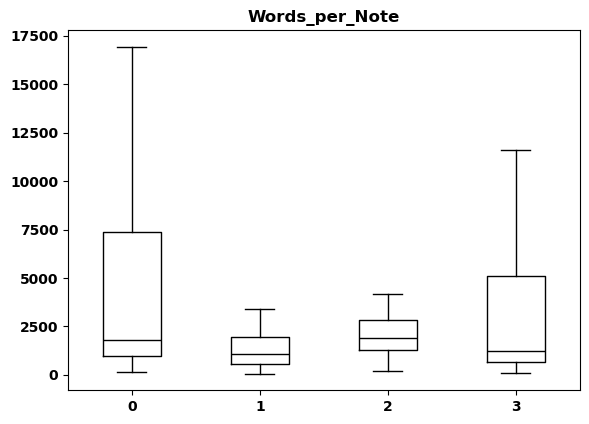

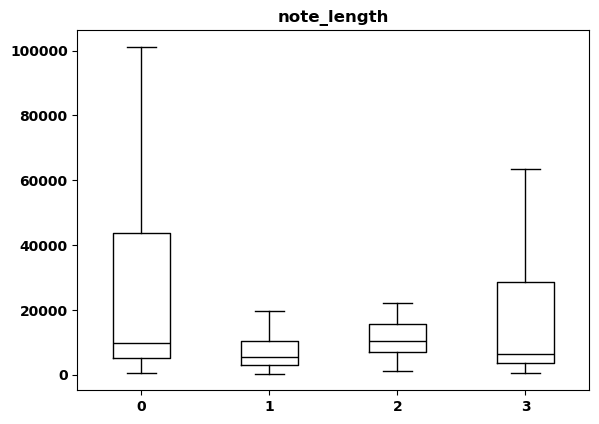

In [24]:
new_df = intsl_train.copy()
new_df['Words_per_Note'] = new_df["text"].str.split().apply(len)
new_df['note_length'] = new_df["text"].apply(len)
# print(intsl_train.columns)
new_df.boxplot('Words_per_Note', by='label', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel("")
plt.show()
new_df.boxplot('note_length', by='label', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel("")
plt.show()



In [25]:
"""  This is extra as an example of pansql

import pandasql as ps

#qintsl = intsl_notes[['subject_id', 'hadm_id']]
# print(qintsl.dtypes)
a1 = "SELECT avg(text_length) FROM \ 
        (select len(text) as text_len from id_train_df) as a "
        

l1 = ps.sqldf(a1, locals())
print(l1) """

'  This is extra as an example of pansql\n\nimport pandasql as ps\n\n#qintsl = intsl_notes[[\'subject_id\', \'hadm_id\']]\n# print(qintsl.dtypes)\na1 = "SELECT avg(text_length) FROM \\ \n        (select len(text) as text_len from id_train_df) as a "\n        \n\nl1 = ps.sqldf(a1, locals())\nprint(l1) '

In [26]:
intsl_train[['id','text', 'icd10_code','label']].groupby(['label'])['id'].nunique()


C:\Users\rolan\AppData\Local\Temp\ipykernel_17308\3653879331.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  intsl_train[['id','text', 'icd10_code','label']].groupby(['label'])['id'].nunique()


label
0    247
1    247
2    247
3    247
Name: id, dtype: int64

<div class="alert alert-block alert-success"><font color="black"><h1><left>Write File with Admission Details and Attached Combined Notes</left></h1></font></div>

In [27]:
path = 'E:/Education/CCSU-Thesis-2024/Data/'
fname = 'intsl_train_group_full_no2d.snappy.parquet'
f2name = 'intsl_test_group_full_no2d.snappy.parquet'
f3name = 'intsl_val1_group_full_no2d.snappy.parquet'
f4name = 'intsl_val2_group_full_no2d.snappy.parquet'

intsl_train.to_parquet(path + fname,compression='snappy',index=None)  
intsl_test.to_parquet(path + f2name,compression='snappy',index=None)  
intsl_val1.to_parquet(path + f3name,compression='snappy',index=None)
intsl_val2.to_parquet(path + f4name,compression='snappy',index=None)


In [228]:
import boto3, os
s3 = boto3.resource('s3')
S3_path = 'Data/' + fname
S3_path2 = 'Data/' + f2name
S3_path3 = 'Data/' + f3name
out_file = path + fname
out_file2 = path + f2name
out_file3 = path + f3name

In [188]:
#s3.meta.client.upload_file(out_file, 'depratti-masters-thesis', S3_path)
#s3.meta.client.upload_file(out_file2, 'depratti-masters-thesis', S3_path2)
#s3.meta.client.upload_file(out_file3, 'depratti-masters-thesis', S3_path3)

In [28]:
print(intsl_train.shape)
print(intsl_test.shape)
print(intsl_val1.shape)
print(intsl_val2.shape)
print(intsl_val2.columns)

(988, 4)
(28, 4)
(12, 4)
(12, 4)
Index(['id', 'text', 'icd10_code', 'label'], dtype='object')


In [29]:
intsl_test.groupby(['icd10_code', 'label'])['id'].nunique()

C:\Users\rolan\AppData\Local\Temp\ipykernel_17308\3889118595.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  intsl_test.groupby(['icd10_code', 'label'])['id'].nunique()


icd10_code  label
A41.9       0        7
            1        0
            2        0
            3        0
I21.4       0        0
            1        7
            2        0
            3        0
J96.00      0        0
            1        0
            2        7
            3        0
N17.9       0        0
            1        0
            2        0
            3        7
Name: id, dtype: int64